/mnt/slurmfs-4090node1/homes/dpeng108/miniforge3/envs/env_transformer_eval/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Loading or creating raw frame-level dataset...
Loading cached dataset from data/cache/train_frames
📊 Training set size: 599681 samples

✅ Action distribution (4 classes):
  Action 0: 10257 (1.71%)
  Action 1: 384615 (64.14%)
  Action 2: 105692 (17.62%)
  Action 3: 99117 (16.53%)

📏 Raw prompt stats:
  Char: min=1065, max=1946, mean=1250.1
  Word: min=113, max=255, mean=138.9

🪙 Tokenizing WITHOUT truncation to get true lengths...


Tokenizing (no truncation): 100%|██████████| 599681/599681 [02:53<00:00, 3457.68 examples/s]



🔢 True tokenized length stats (NO TRUNCATION):
  Min: 544
  Max: 769  ← 🚨 This is the real maximum!
  Mean: 589.8
  >1024 tokens: 0 samples (0.00%)
📈 True token length plot saved to: outputs/l2a_longformer_action_classifier/true_tokenized_length.png

🧪 Longest example (index 385134, length=769):
Original prompt (first 400 chars):
Observation Grid:
[0,0]: depth=1.46, sem=wall; [0,1]: depth=1.08, sem=chest_of_drawers; [0,2]: depth=0.99, sem=chest_of_drawers; [0,3]: depth=0.86, sem=chest_of_drawers; [0,4]: depth=0.74, sem=chest_of_drawers; [0,5]: depth=0.58, sem=chest_of_drawers
[1,0]: depth=1.23, sem=wall; [1,1]: depth=0.72, sem=chest_of_drawers; [1,2]: depth=0.61, sem=chest_of_drawers; [1,3]: depth=0.56, sem=chest_of_drawer...

Token length: 769
📄 Longest example saved to: outputs/l2a_longformer_action_classifier/longest_example.txt

💡 Recommendation for MAX_LENGTH (based on percentiles):
  90% of samples ≤ 610 tokens
  95% of samples ≤ 619 tokens
  99% of samples ≤ 647 tokens
  To kee

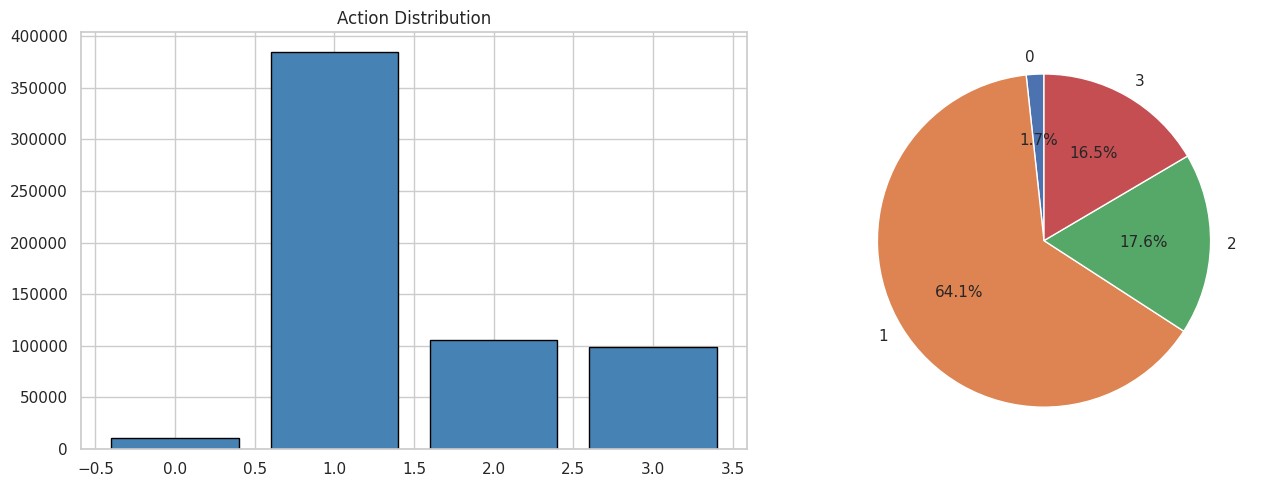

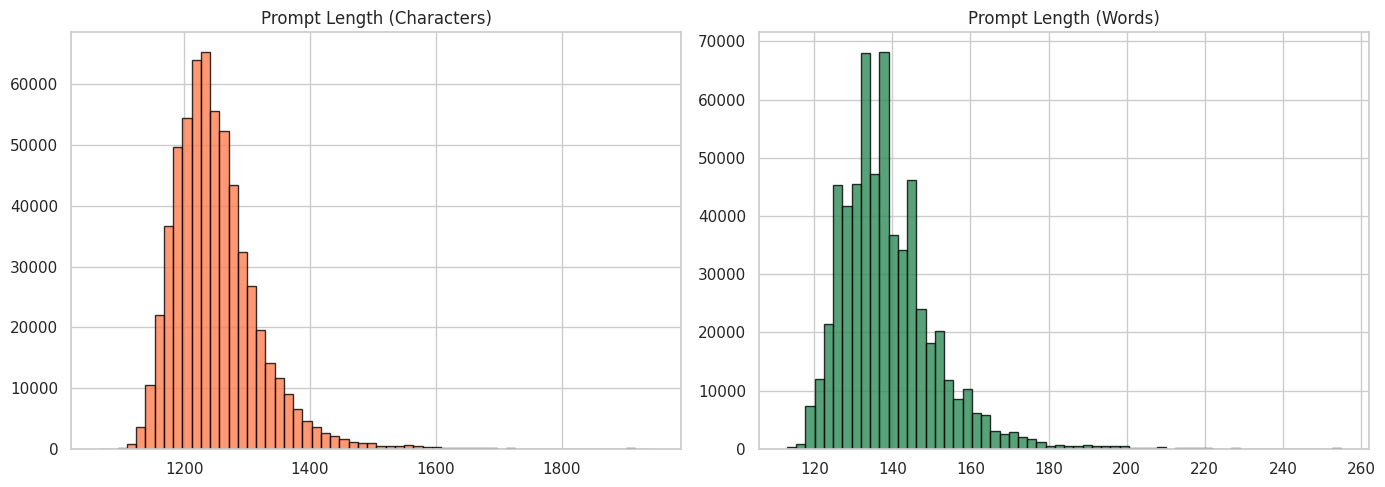

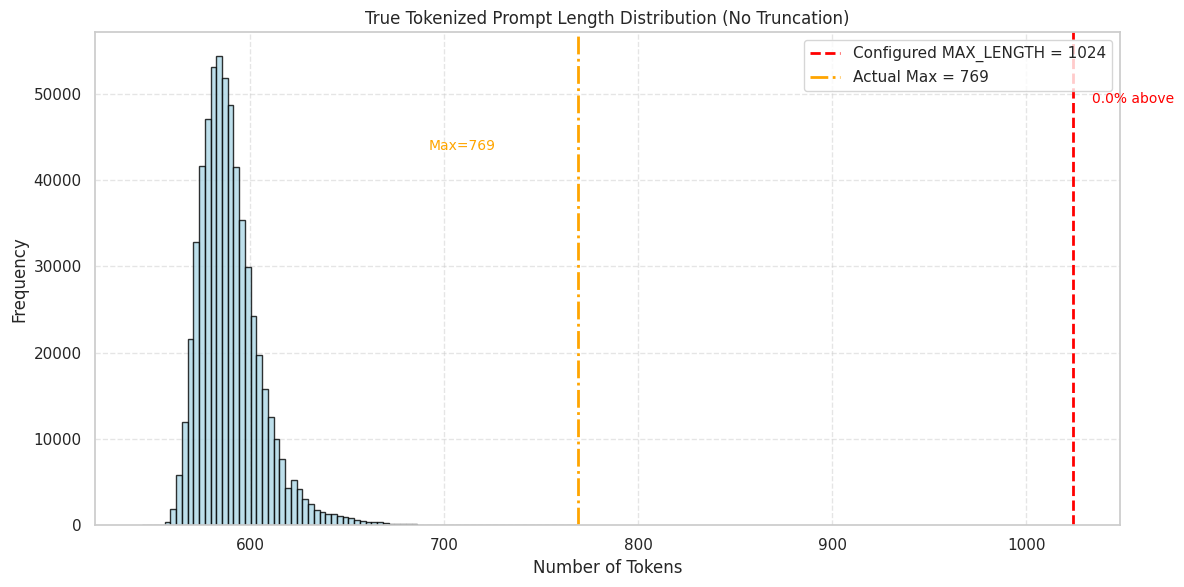

In [ ]:
# feature_analysis.py (v2: 无截断分析真实长度分布)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datasets import load_from_disk
import warnings
warnings.filterwarnings("ignore")

# ======================
# 配置（与 train.py 一致）
# ======================
DATA_DIR = "../data/l2am_r2r"
CACHE_DIR = "../data/cache/train_frames"
HF_CACHE_DIR = "../data/hf_model_cache"
MODEL_NAME = "allenai/longformer-base-4096"
MAX_LENGTH = 1024  # 仅作为参考阈值，不用于截断
OUTPUT_DIR = "../outputs/l2a_longformer_action_classifier"

from dataset_utils import get_or_create_dataset

# 注意：这里我们不使用 tokenize_function（因为它默认 truncation=True）
# 而是自定义一个无截断的 tokenize 函数用于分析
def tokenize_for_analysis(examples, tokenizer):
    """仅用于分析：不截断、不 padding，获取真实 token 长度"""
    return tokenizer(
        examples["prompt"],
        truncation=False,      # ← 关键：不截断
        padding=False,
        max_length=None,       # ← 不设上限
        add_special_tokens=True
    )

sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 11})
os.makedirs(OUTPUT_DIR, exist_ok=True)


def main():
    print("🔍 Loading or creating raw frame-level dataset...")
    raw_ds = get_or_create_dataset(DATA_DIR, CACHE_DIR)

    ds_split = raw_ds.train_test_split(test_size=0.05, seed=42)
    train_ds = ds_split["train"]
    print(f"📊 Training set size: {len(train_ds)} samples")

    # ==============================
    # 1. Action 分布（不变）
    # ==============================
    actions = train_ds["action"]
    action_counter = Counter(actions)
    print(f"\n✅ Action distribution ({len(action_counter)} classes):")
    for action, count in sorted(action_counter.items()):
        print(f"  Action {action}: {count} ({count / len(actions) * 100:.2f}%)")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    labels, counts = zip(*sorted(action_counter.items()))
    axes[0].bar(labels, counts, color="steelblue", edgecolor="black")
    axes[0].set_title("Action Distribution")
    axes[1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "action_distribution.png"), dpi=300, bbox_inches='tight')

    # ==============================
    # 2. 原始 Prompt 长度（字符 & 词）
    # ==============================
    prompts = train_ds["prompt"]
    char_lens = [len(p) for p in prompts]
    word_lens = [len(p.split()) for p in prompts]
    print(f"\n📏 Raw prompt stats:")
    print(f"  Char: min={min(char_lens)}, max={max(char_lens)}, mean={np.mean(char_lens):.1f}")
    print(f"  Word: min={min(word_lens)}, max={max(word_lens)}, mean={np.mean(word_lens):.1f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].hist(char_lens, bins=60, color="coral", edgecolor="black", alpha=0.8)
    axes[0].set_title("Prompt Length (Characters)")
    axes[1].hist(word_lens, bins=60, color="seagreen", edgecolor="black", alpha=0.8)
    axes[1].set_title("Prompt Length (Words)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "raw_prompt_length.png"), dpi=300, bbox_inches='tight')

    # ==============================
    # 3. Tokenized 长度分析（无截断！）
    # ==============================
    from transformers import AutoTokenizer
    print("\n🪙 Tokenizing WITHOUT truncation to get true lengths...")
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        cache_dir=HF_CACHE_DIR,
        clean_up_tokenization_spaces=True
    )

    tokenized_ds = train_ds.map(
        lambda x: tokenize_for_analysis(x, tokenizer),
        batched=True,
        remove_columns=[col for col in train_ds.column_names if col != "prompt"],
        desc="Tokenizing (no truncation)"
    )
    token_lengths = [len(ids) for ids in tokenized_ds["input_ids"]]

    max_actual_len = max(token_lengths)
    num_exceed_max = sum(l > MAX_LENGTH for l in token_lengths)
    exceed_ratio = num_exceed_max / len(token_lengths)

    print(f"\n🔢 True tokenized length stats (NO TRUNCATION):")
    print(f"  Min: {min(token_lengths)}")
    print(f"  Max: {max_actual_len}  ← 🚨 This is the real maximum!")
    print(f"  Mean: {np.mean(token_lengths):.1f}")
    print(f"  >{MAX_LENGTH} tokens: {num_exceed_max} samples ({exceed_ratio * 100:.2f}%)")

    # 可视化完整分布
    plt.figure(figsize=(12, 6))
    n, bins, patches = plt.hist(token_lengths, bins=min(200, max_actual_len // 10), 
                                color="lightblue", edgecolor="black", alpha=0.8)

    # 添加参考线
    plt.axvline(MAX_LENGTH, color="red", linestyle="--", linewidth=2, label=f"Configured MAX_LENGTH = {MAX_LENGTH}")
    plt.axvline(max_actual_len, color="orange", linestyle="-.", linewidth=2, label=f"Actual Max = {max_actual_len}")

    # 添加文本标注
    plt.text(MAX_LENGTH + 10, max(n) * 0.9, f"{exceed_ratio * 100:.1f}% above", color="red", fontsize=10)
    plt.text(max_actual_len - max_actual_len*0.1, max(n) * 0.8, f"Max={max_actual_len}", color="orange", fontsize=10)

    plt.title("True Tokenized Prompt Length Distribution (No Truncation)")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, "true_tokenized_length.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📈 True token length plot saved to: {plot_path}")

    # ==============================
    # 4. 编码示例（取最长的那个！更直观）
    # ==============================
    # longest_idx = np.argmax(token_lengths)
    longest_idx = np.argmax(token_lengths).item()
    orig_prompt = train_ds[longest_idx]["prompt"]
    input_ids = tokenized_ds[longest_idx]["input_ids"]
    decoded = tokenizer.decode(input_ids, skip_special_tokens=False)

    print(f"\n🧪 Longest example (index {longest_idx}, length={len(input_ids)}):")
    snippet = orig_prompt[:400] + "..." if len(orig_prompt) > 400 else orig_prompt
    print(f"Original prompt (first 400 chars):\n{snippet}\n")
    print(f"Token length: {len(input_ids)}")

    with open(os.path.join(OUTPUT_DIR, "longest_example.txt"), "w", encoding="utf-8") as f:
        f.write(f"Index: {longest_idx}\n")
        f.write(f"Token length: {len(input_ids)}\n\n")
        f.write("=== Original Prompt ===\n")
        f.write(orig_prompt + "\n\n")
        f.write("=== Input IDs ===\n")
        f.write(str(input_ids) + "\n\n")
        f.write("=== Decoded ===\n")
        f.write(decoded + "\n")
    print(f"📄 Longest example saved to: {os.path.join(OUTPUT_DIR, 'longest_example.txt')}")

    # ==============================
    # 5. 建议：推荐 MAX_LENGTH 设置
    # ==============================
    percentiles = [90, 95, 99]
    print(f"\n💡 Recommendation for MAX_LENGTH (based on percentiles):")
    for p in percentiles:
        val = int(np.percentile(token_lengths, p))
        print(f"  {p}% of samples ≤ {val} tokens")
    print(f"  To keep all samples, need MAX_LENGTH ≥ {max_actual_len}")

    print("\n✅ Feature analysis completed!")


if __name__ == "__main__":
    main()